In [2]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

from curve import Curve

In [3]:
# these dont have to be build functions anymore, can just be model objects
def build_handles_model():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')
def build_composite_model():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                             independent_max = 90) + lk.force_offset('handles')

In [4]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 10},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 200},  # was 250 200 to 600 is acceptable
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': False}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

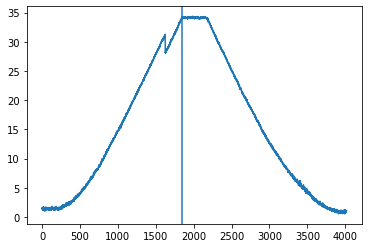

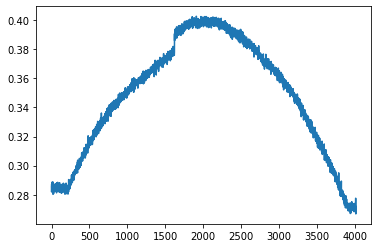

In [6]:
datasets = [{'filename': '/home/kris/proj/.data/tweez/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]
adkurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    #print(data.fdcurves)
    for curve_id in dataset['curve_ids']:
        original = data.fdcurves[curve_id]
        fdata = data.fdcurves[curve_id].f.data
        ddata = data.fdcurves[curve_id].d.data
        if True:
            fdata = fdata[ddata > 0]
            ddata = ddata[ddata > 0]
        adkurves[curve_id] = Curve(curve_id, ddata, fdata)
        # we don't need the id in two different place
plt.plot(adkurves['adk5_curve3'].force_data)
plt.axvline(1850)

pull_force = adkurves['adk5_curve3'].force_data
pull_dist = adkurves['adk5_curve3'].dist_data
plt.figure()
plt.plot(pull_dist)

In [ ]:
from util import load_estimates, extract_estimates, thresholding_algo
    
def compute_bic(force, dist, ests):
    fit = lk.FdFit(build_handles_model())
    fit.add_data('slice', force, dist)
    load_estimates(fit, ests)
    bic = fit.bic
    fit.fit()
    return (bic, extract_estimates(fit))


def group_continuous(indices):
    groups = [[indices[0][0]]] # np.argwhere returns array of single-element arrays
    current_group = 0
    for index in indices[1:]:
        index = index[0]
        if index == groups[current_group][-1] + 1:
            groups[current_group].append(index)
        else:
            groups.append([index])
            current_group += 1
    return groups


def stupid_interp(data, len_factor):
    interp_data = []
    for point in data:
        for replicate in range(len_factor):
            interp_data.append(point)
    return interp_data
    
    
def zoom_unfold(force, dist, first_index, almost_peak, end_peak):
    print(first_index, almost_peak, end_peak)
    ref_fit = lk.FdFit(build_handles_model())
    ref_fit.add_data('before', force[first_index:almost_peak], dist[first_index:almost_peak])
    ref_fit.fit()
    ests = extract_estimates(ref_fit)
    bix = []
    for index in range(almost_peak, end_peak):
        (bic, ests) = compute_bic(force[first_index:index], dist[first_index:index], ests)
        bix.append(bic)
    peaksign = thresholding_algo(np.diff(bix), len(bix)// 2, 4., 0)['signals']
    print('max dbic', np.argmax(np.diff(bix)))
    #plt.plot(force)
    #plt.figure()
    #plt.plot(np.diff(bix))
    return np.argmax(np.diff(bix)) + almost_peak
    #return np.where(peaksign >= 1)[0] + almost_peak


def running_fit(force, dist, first_index, last_index, slice_width):
    slices = [slice(first_index, i * slice_width + slice_width) for i in range(first_index // slice_width,
                                                                              last_index // slice_width)]
    fit = lk.FdFit(build_handles_model())
    fit.add_data('first', force[slices[0]], dist[slices[0]])
    fit.fit()
    ests = extract_estimates(fit)
    bix = []
    for slc in slices: # /online/ peak-finding?
        (bic, ests) = compute_bic(force[slc], dist[slc], ests)
        bix.append(bic)
        
    peaksign = thresholding_algo(np.diff(bix), len(bix) // 2, 4., 0)['signals']
                                                    # these parameters are awkward
    peaksign_interp = np.asarray(stupid_interp(peaksign, slice_width))
    grouped_peak_signals = group_continuous(np.argwhere(peaksign_interp >= 1) + first_index)
    exact_unfolds = []
    for group in grouped_peak_signals:
        exact_unfolds.append(zoom_unfold(force, dist, first_index, group[0] - slice_width, group[-1]))
    print(exact_unfolds, len(groups))
    return {'slices': slices, 'bix': bix, 
            'signals': peaksign, 'groups': grouped_peak_signals, 
            'unfolds': exact_unfolds}

results = running_fit(pull_force, pull_dist, 800, 1850, 50)

plt.plot(pull_force)
for unfold in results['unfolds']:
    plt.axvline(unfold)
results['unfolds']
print(results['groups'])
plt.figure()
plt.plot(pull_force[results['groups'][0]])

[90]
[0.34090909]


TypeError: iteration over a 0-d array

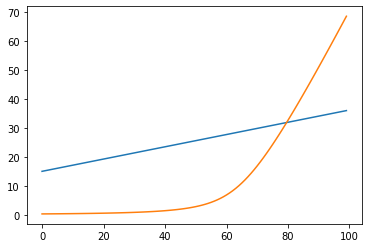

In [106]:
from copy import deepcopy

def compute_unfold_dists(unfold_forces, cls, handle_estimates, protein_estimates):
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein') \
                                    + lk.force_offset('handles').invert()
    hm = lk.odijk('handles') + lk.force_offset('handles').invert()
    cm = comp_wrt_f
    h_est = deepcopy(handle_estimates)
    p_ests = [deepcopy(protein_estimates) for force in unfold_forces]
    #hm = build_handles_model()
    #cm = build_composite_model()
    fits = [lk.FdFit(hm), *[lk.FdFit(hm,cm) for force in unfold_forces]]
    fits[0].add_data('junk', [0,1], [0,1])
    load_estimates(fits[0], h_est)
    cl_total = 0
    unfold_dists = []
    for est,cl,fit,force in zip(p_ests,cls,fits[1:],unfold_forces):
        cl_total += cl
        est['protein/Lc']['value'] = cl_total
        fit[cm].add_data('junk', [0,1], [0,1])
        load_estimates(fit, h_est)
        load_estimates(fit, est)
        unfold_dists.append(cm(force, fit))
    return unfold_dists
        
    
def compute_max_dist(unfold_forces, cls, handle_estimates, protein_estimates):
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    hestimates = deepcopy(handle_estimates)
    pestimates = deepcopy(protein_estimates)
    pestimates['protein/Lc']['value'] = 0.001 #sum(cls)
    fit = lk.FdFit(build_composite_model())
    #junk = (np.linspace(0.28,0.3,100), np.linspace(0,20,100))
    fit.add_data('junk', np.linspace(0.28,0.3,100), np.linspace(0,20,100))
    load_estimates(fit, pestimates)
    load_estimates(fit, handle_estimates)
    coarse_dists = np.linspace(0.15, (sum(cls) + 0.3), 100)
    coarse_force = build_composite_model()(coarse_dists, fit)
    index = np.argwhere(coarse_force >= max(unfold_forces))[0]
    plt.plot(coarse_dists * 100)
    plt.plot(coarse_force)
    print(index)
    return coarse_dists[index]
    
def better_sim(unfold_forces, cls, handle_estimates_orig, protein_estimates_orig,
              stds={'dist': 0.00195, 'force':0.105}):
    model_h = build_handles_model()
    model_c = build_composite_model()
    fit = lk.FdFit(model_h,model_c)
    fit[model_h].add_data('junk', *(np.linspace(0.28,0.3,100), np.linspace(0,20,100)))
    fit[model_c].add_data('junk', *(np.linspace(0.28,0.3,100), np.linspace(0,20,100)))
    
    handle_estimates = deepcopy(handle_estimates_orig)
    for param in handle_estimates.values():
        param['fixed'] = True
    protein_estimates = deepcopy(protein_estimates_orig)
    for param in protein_estimates.values():
        param['fixed'] = True
        
    #max_dist = 
    pull_dists = np.linspace(0.28,)
    #for index, unfold_force in enumerate(unfold_forces)

print(compute_max_dist([30, 40, 50], [0.01, 0.02,0.03], handle_estimates, protein_estimates))
print(compute_unfold_dists([30, 40, 50], [0.01, 0.02,0.03], handle_estimates, protein_estimates))
plt.figure()
plt.plot(pull_dist)
        

In [88]:
from simulate import gen_hm, gen_comp
comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein') + lk.force_offset('handles').invert()
testfit = lk.FdFit(comp_wrt_f)
testfit.add_data('aaa',[0,1],[0,2])
print(testfit)
load_estimates(testfit, handle_estimates)
load_estimates(testfit, protein_estimates)
print(testfit)

def generate_fd(first_unf, cls, handle_estimates_orig, protein_estimates_orig,
                stds={'dist': 0.00195, 'force': 0.105}):
    model_h = gen_hm()
    model_c = gen_comp()
    fit = lk.FdFit(model_h, model_c)
    junk = (np.linspace(0.28,0.3,100), np.linspace(0,20,100))
    fit[model_h].add_data('junk', *junk)
    fit[model_c].add_data('junk', *junk)

    handle_estimates = deepcopy(handle_estimates_orig)
    protein_estimates = deepcopy(protein_estimates_orig)
    for param in handle_estimates.values():
        param['fixed'] = True
    for param in protein_estimates.values():
        param['fixed'] = True
    load_estimates(fit, handle_estimates)
    load_estimates(fit, protein_estimates)
    fit['protein/Lc'].value = cls[0]

    unfold_dist = first_unf
    stop_dist = unfold_dist + sum(cls)
    print(stop_dist)
    pull_dists = np.linspace(0.28, stop_dist, 2000)
    distances = [pull_dists[pull_dists < unfold_dist]]
    forces = [model_h(distances[0], fit)]
    total_cl = 0
    for index, cl in enumerate(cls):
        newdist = pull_dists[pull_dists >= unfold_dist]
        # print(len(newdist))
        unfold_dist += cl
        # print(index, cl, len(cls))
        if index < len(cls) - 1:
            newdist = newdist[newdist < unfold_dist]
        distances.append(newdist)
        total_cl += cl
        fit['protein/Lc'].value = total_cl
        newforce = model_c(newdist, fit)
        forces.append(newforce)
    stat_dists = np.zeros(500) + stop_dist
    stat_forces = np.zeros(500) + model_c(stop_dist, fit)
    distances.append(stat_dists)
    forces.append(stat_forces)
    relax_dists = np.linspace(stop_dist, 0.28, 2000) 
    relax_forces = model_c(relax_dists, fit)
    distances.append(relax_dists)
    forces.append(relax_forces)
    concdists = np.concatenate(distances, axis=None)
    concforces = np.concatenate(forces, axis=None)
    noisy_dists = concdists + np.random.normal(0, stds['dist'], len(concdists))
    noisy_forces = concforces + np.random.normal(0, stds['force'], len(concforces))
    return (noisy_dists, noisy_forces)


#gens = generate_fd(0.38, [0.020, 0.025, 0.035])

# plt.figure(figsize=(8,14))
# plt.subplot(2, 1, 1)
# plt.plot(*gens, '.', c='tab:blue')
# plt.subplot(2, 1, 2)
# plt.plot(gens[1], '.', c='tab:blue')
# plt.savefig('sim_test.png')


Fit
  - Model: handles_with_protein_with_inv(handles)
  - Equation:
      d(f) = handles.Lc * (1 - (1/2)*sqrt(kT/(f*handles.Lp)) + f/handles.St) + argmin[d](norm((1/4) * (1 - (d/protein.Lc))**(-2) - (1/4) + (d/protein.Lc)-f*protein.Lp/kT)) + argmin[d](norm(handles.f_offset-f))

  - Data sets:
    - FitData(aaa, N=2)

  - Fitted parameters:
    Name                Value  Unit      Fitted      Lower bound    Upper bound
    ----------------  -------  --------  --------  -------------  -------------
    handles/Lp          40     [nm]      True                0            100
    handles/Lc          16     [micron]  True                0            inf
    handles/St        1500     [pN]      True                0            inf
    kT                   4.11  [pN*nm]   False               0              8
    protein/Lp          40     [nm]      True                0            100
    protein/Lc          16     [micron]  True                0            inf
    handles/f_offset     0.01 

0.44


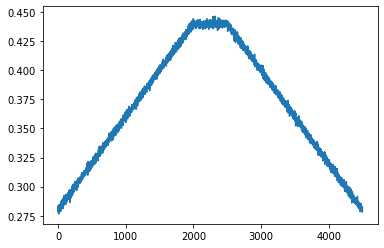

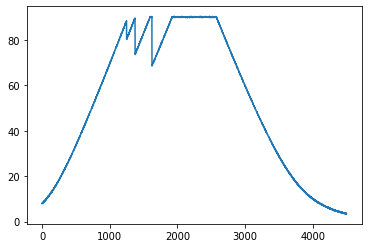

In [73]:

#from simulate import generate_fd
sim_curve = [*generate_fd(0.38, [0.01, 0.02, 0.03], handle_estimates, protein_estimates)]
plt.plot(sim_curve[0])
plt.figure()
plt.plot(sim_curve[1])